In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [7]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = True
overlap_thr= 0
greater_than=True

overlap_str = 'greaterthan' if greater_than else ''
test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print('making dirs')
print(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single


## Output dirs

In [8]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
curr_dst_dir = os.path.join(basedir, 'controls', 'match_rfs')

if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'generalization')

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs
dff-ROC__stimulus__matchRF__C1.00


## Check input data

In [9]:
import _pickle as pkl
input_id = '__'.join(aggr_id.split('__')[0:-1])
input_files = glob.glob(os.path.join(basedir, 'files', 
                                     'inputcells-*_%s.pkl' % input_id))
#input_files = glob.glob(os.path.join(basedir, 'files', 'inputcells*.pkl'))
print(len(input_files))
#input_fpath = input_files[0]
i_=[]
for ipath in input_files:
    with open(ipath, 'rb') as f:
        icells = pkl.load(f)
    i_.append(icells)
inputcells = pd.concat(i_, axis=0)

3


In [10]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

<IPython.core.display.Javascript object>


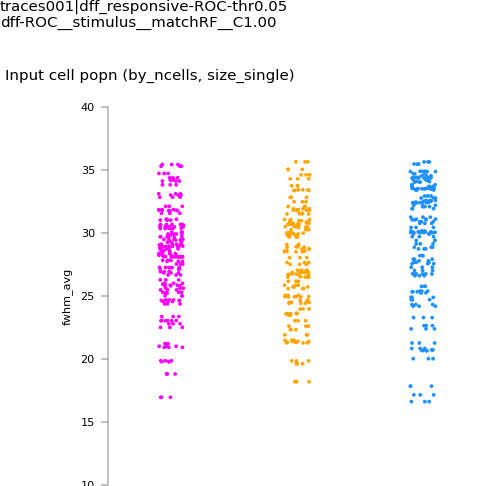

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs input_cell_distributiongreaterthan


In [78]:
fig, ax = pl.subplots(figsize=(4,4), dpi=150)

sns.stripplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, s=2,
              palette=area_colors, order=visual_areas, zorder=-1000)
# sns.pointplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='k', order=visual_areas, scale=0.5, errwidth=0.5, join=False,
#              markers='_', zorder=1000, ci='sd', estimator=np.median)
ax.set_ylim((10, 40))
pl.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
# sns.boxplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='w', order=visual_areas, fliersize=0)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
fig.text(0.01, 0.85, 'Input cell popn (%s, %s)' % (analysis_type, test_type), 
         fontsize=8)
figname = 'input_cell_distribution%s' % (overlap_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(curr_dst_dir, figname)

In [13]:
aggr_id

'dff-ROC__stimulus__matchRF__C1.00'

## Load

In [14]:

if match_rfs:
    max_ncells=73 if greater_than else 94 
    special_cases = [169, 120, 46, 94] if greater_than else [169, 120, 46, 73]
else:
    max_ncells=120 if greater_than else 141
    special_cases = [169, 46, 94, 73, 141] if greater_than else [169, 46, 94, 73, 120]
print("max_ncells=%i (match RF: %s, overlap_thr, greater_than? %s)" \
      % (max_ncells, str(match_rfs), str(greater_than)))

max_ncells=73 (match RF: True, overlap_thr, greater_than? True)


In [15]:
# max_ncells = 96 #96 # if match_rfs and (responsive_test=='ROC')
# max_ncells = 94
# special_cases = [169, 120, 46]
experiment = 'gratings' if class_name=='ori' else 'blobs'
i_=[]
for match_rf_flag in [True, False]:
    iterdf_, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=None,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rf_flag, 
                          overlap_thr=0) # if match_rf_flag is False else None)

    sample_sizes = [s for s in sorted(iterdf_['n_cells'].unique()) if s <=max_ncells\
                   and s not in special_cases]
    iterdf_ = iterdf_[iterdf_['n_cells'].isin(sample_sizes)]
    iterdf_['rfs'] = 'matched' if match_rf_flag else 'all'
    iterdf_['match_rfs'] = match_rf_flag
    i_.append(iterdf_)
iterdf = pd.concat(i_, axis=0, ignore_index=True) #.dropna()

(Li) Found 10 paths
(Lm) Found 10 paths
(V1) Found 10 paths
(Li) Found 14 paths
(Lm) Found 14 paths
(V1) Found 15 paths


In [16]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
itershuff, missing_shuff = dec.load_iterdf(meta, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr,
                          shuffle_visual_area=True)

(Li) Found 8 paths
(Lm) Found 8 paths
(V1) Found 8 paths


In [17]:
max_ncells

73

In [18]:
# max_ncells=94    
m_=[]
for rf_cond, iterdf_ in iterdf.groupby('rfs'):
    # Group means
    grouper = ['visual_area', 'condition', 'iteration']
    mean_ = dec.average_within_iterations_by_ncells(iterdf_, 
                                analysis_type=analysis_type, test_type=test_type,
                                grouper=grouper) 
    mean_['rfs'] = rf_cond
    #mean_['match_rfs'] = match_rf_flag
    m_.append(mean_)
mean_df = pd.concat(m_, axis=0).reset_index(drop=True)

In [19]:
n_iters = iterdf['iteration'].max() +1
xlabels = [1, 32, 64, 96, max_ncells]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("rfs:", mean_df['rfs'].unique(), mean_df['match_rfs'].unique())

mean_df['novel_labels'] = None
mean_df.loc[mean_df['novel'], 'novel_labels'] = 'novel'
mean_df.loc[~mean_df['novel'], 'novel_labels'] = 'trained'

novel: [False  True]
conditions: ['data' 'shuffled']
rfs: ['all' 'matched'] [False  True]


In [20]:
mean_df.groupby(['visual_area', 'condition', 'train_transform', 'test_transform', 'novel', 'rfs', 'n_cells']).count()

iteration  \
visual_area condition train_transform test_transform novel rfs     n_cells              
Li          data      30.0            30.0           False all     1             1000   
                                                                   2             1000   
                                                                   4             1000   
                                                                   8             1000   
                                                                   16            1000   
...                                                                               ...   
V1          shuffled  30.0            30.0           False matched 8             1000   
                                                                   16            1000   
                                                                   32            1000   
                                                                   64            1000   
                                                                   73            1000   

                                                                            fit_time  \
visual_area condition train_transform test_transform novel rfs     n_cells             
Li          data      30.0            30.0           False all     1            1000   
                                                                   2            1000   
                                                                   4            1000   
                                                                   8            1000   
                                                                   16           1000   
...                                                                              ...   
V1          shuffled  30.0            30.0           False matched 8            1000   
                                                                   16           1000   
                                                                   32           1000   
                                                                   64           1000   
                                                                   73           1000   

                                                                            score_time  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1              1000   
                                                                   2              1000   
                                                                   4              1000   
                                                                   8              1000   
                                                                   16             1000   
...                                                                                ...   
V1          shuffled  30.0            30.0           False matched 8              1000   
                                                                   16             1000   
                                                                   32             1000   
                                                                   64             1000   
                                                                   73             1000   

                                                                            test_score  \
visual_area condition train_transform test_transform novel rfs     n_cells               
Li          data      30.0            30.0           False all     1              1000   
                                                                   2              1000   
                                                                   4              1000   
                                                                   8              1000   
                                                              

In [21]:
print_index = ['visual_area','rfs', 'novel']

if test_type is not None:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'novel', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=print_index, columns='n_cells')
else:
    score_table = mean_df[(mean_df.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'rfs'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area'], columns='n_cells')
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: blobs (class=morphlevel): dff-ROC__stimulus__matchRF__C1.00


heldout_test_score                                \
n_cells                                   1         2         4         8    
visual_area rfs     novel                                                    
Li          all     False           0.530165  0.548632  0.572858  0.608608   
                    True            0.525862  0.542373  0.561702  0.585461   
            matched False           0.538638  0.563467  0.594467  0.626742   
                    True            0.537238  0.556639  0.584637  0.611063   
Lm          all     False           0.535350  0.551167  0.575150  0.601300   
                    True            0.518964  0.529512  0.538964  0.550413   
            matched False           0.526867  0.539533  0.558233  0.571117   
                    True            0.519040  0.527257  0.542787  0.555690   
V1          all     False           0.540002  0.563712  0.589400  0.624117   
                    True            0.521925  0.532962  0.549526  0.567125   
            matched False           0.547856  0.578306  0.622083  0.664583   
                    True            0.525184  0.540310  0.564486  0.585809   

                                                                   
n_cells                          16        32        64        73  
visual_area rfs     novel                                          
Li          all     False  0.636083  0.663242  0.720925  0.731742  
                    True   0.611529  0.630685  0.672809  0.681050  
            matched False  0.656283  0.692350  0.746292  0.748575  
                    True   0.637539  0.661543  0.700512  0.707529  
Lm          all     False  0.631617  0.654300  0.707900  0.714400  
                    True   0.563172  0.574607  0.601428  0.606714  
            matched False  0.597783  0.612867  0.640700  0.649133  
                    True   0.569302  0.581053  0.601243  0.606916  
V1          all     False  0.660183  0.696467  0.767083  0.785067  
                    True   0.584550  0.604220  0.646126  0.654890  
            matched False  0.701367  0.739850  0.796483  0.807817  
                    True   0.607674  0.632227  0.666165  0.671684

In [22]:
area_colors2 = {'V1': 'darkmagenta', 'Lm': 'saddlebrown', 'Li': 'darkblue'}

In [23]:
pl.rcParams['legend.title_fontsize'] = 8


<IPython.core.display.Javascript object>


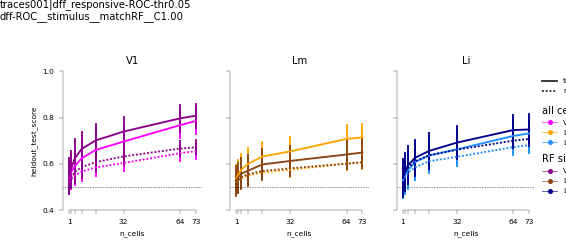

2 [<matplotlib.lines.Line2D object at 0x2acc4a3193d0>, <matplotlib.lines.Line2D object at 0x2acc4a319b10>, <matplotlib.lines.Line2D object at 0x2acc4a320250>, <matplotlib.lines.Line2D object at 0x2acc4a320950>]
1 [<matplotlib.lines.Line2D object at 0x2acc4a381490>, <matplotlib.lines.Line2D object at 0x2acc4a38d350>, <matplotlib.lines.Line2D object at 0x2acc4a38da50>, <matplotlib.lines.Line2D object at 0x2acc4a395190>]
2
0 [<matplotlib.lines.Line2D object at 0x2acc4a33f9d0>, <matplotlib.lines.Line2D object at 0x2acc4a359750>, <matplotlib.lines.Line2D object at 0x2acc4a32c3d0>, <matplotlib.lines.Line2D object at 0x2acc4a319d50>]
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs accuracy_byncell_curves_matchRF-v-all_train-v-novelgreaterthan


In [72]:
metric='heldout_test_score'

plotd = mean_df[mean_df.condition=='data']

#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)

for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]; ax.set_title(va);
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='all'], ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors[va])
    sns.lineplot(x='n_cells', y=metric, data=df_[df_.rfs=='matched'],ax=ax,
            style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
            color=area_colors2[va])
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.set_ylim([0.4, 1])
    print(ai, ax.legend_.legendHandles)
    if ai==1:
        leg_h = ax.legend_.legendHandles[0:2]
        print(len(leg_h))
        leg = ax.legend(handles=leg_h, bbox_to_anchor=(2.2,1.), loc='upper left', 
                  frameon=False)
        leg._legend_box.align = "left"
    else:
        ax.legend_.remove()
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_box_aspect(1)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

leg_h2 = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[-1].legend(handles=leg_h2, bbox_to_anchor=(1,0.8), loc='upper left', 
               frameon=False, title='all cells')
leg._legend_box.align = "left"

leg_h3 = pplot.custom_legend_markers(colors=[area_colors2[v] for v in visual_areas], 
                                     labels=visual_areas, markers='.')
leg = axn[0].legend(handles=leg_h3, bbox_to_anchor=(3.4,0.45), loc='upper left', 
               frameon=False, title='RF size-matched', fontsize=6)
leg._legend_box.align = "left"

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, wspace=0.2, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'accuracy_byncell_curves_matchRF-v-all_train-v-novel%s' % (overlap_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [73]:
import itertools
max_ncells

73

In [74]:
plotd = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]
plotd.head()


,visual_area,condition,iteration,n_cells,novel,fit_time,score_time,test_score,train_score,heldout_test_score,...,randi,train_transform,test_transform,n_trials,randi_cells,intact,overlap_thr,match_rfs,rfs,novel_labels
14,Li,data,0,73,False,0.001461,0.000357,0.731111,1.0,0.800000,...,6280.8,30.0,30.0,58.0,8456.0,True,0.0,False,all,trained
15,Li,data,0,73,True,0.001461,0.000357,0.731111,1.0,0.687931,...,6280.8,30.0,30.0,58.0,8456.0,True,0.0,False,all,novel
30,Li,data,1,73,False,0.000828,0.000343,0.781333,1.0,0.766667,...,5991.4,30.0,30.0,58.0,8940.0,True,0.0,False,all,trained
31,Li,data,1,73,True,0.000828,0.000343,0.781333,1.0,0.687931,...,5991.4,30.0,30.0,58.0,8940.0,True,0.0,False,all,novel
46,Li,data,2,73,False,0.000743,0.000304,0.620000,1.0,0.650000,...,5040.0,30.0,30.0,38.0,2936.0,True,0.0,False,all,trained


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


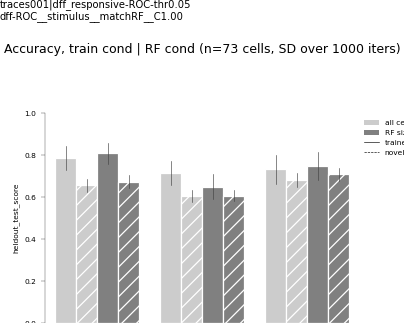

In [75]:
%matplotlib notebook
plotd['plotcond'] = ['%s_%s' %  (r, n) for r, n in plotd[['rfs', 'novel_labels']].values]

matchrf_color = [0.5]*3
all_color = [0.8]*3
plot_palette = {'all_trained': all_color, 'all_novel': all_color,
                'matched_trained': matchrf_color, 'matched_novel': matchrf_color}
keys = ['all_trained', 'all_novel', 'matched_trained', 'matched_novel']

fig, ax = pl.subplots(figsize=(5,4))
sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
           hue='plotcond', hue_order=keys, palette=plot_palette, 
           edgecolor='w', order=visual_areas, ci='sd', errwidth=0.5)
# legends
leg_h = pplot.custom_legend_markers(colors=[all_color, matchrf_color],
                                    labels=['all cells', 'RF size-matched'],
                                    use_patch=True)
leg_h2 = pplot.custom_legend_markers(colors=['k', 'k'],
                                    labels=['trained', 'novel'],markers=None,
                                    linestyles=['-', '--'], use_patch=False)
ax.legend(handles=leg_h+leg_h2, bbox_to_anchor=(0.99,1), 
          loc='upper left', frameon=False)

bar_locs = 3
hatches = itertools.cycle(['', '//'])
for i, bar in enumerate(ax.patches):
    if i % bar_locs == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set_aspect(2, anchor='SW')
ax.set_ylim([0, 1])
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
fig.text(0.01, 0.85,\
         'Accuracy, train cond | RF cond (n=%i cells, SD over %i iters)' \
         % (max_ncells, n_iters))

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'compare_performance_matchRF-v-all_train-v-novel_%s' % (overlap_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [76]:
data_ = mean_df[(mean_df['n_cells']==max_ncells) 
            & (mean_df['condition']=='data')].copy().reset_index(drop=True)
data_.groupby(['visual_area', 'novel', 'rfs']).count()

condition  iteration  n_cells  fit_time  \
visual_area novel rfs                                                
Li          False all           1000       1000     1000      1000   
                  matched       1000       1000     1000      1000   
            True  all           1000       1000     1000      1000   
                  matched       1000       1000     1000      1000   
Lm          False all           1000       1000     1000      1000   
                  matched       1000       1000     1000      1000   
            True  all           1000       1000     1000      1000   
                  matched       1000       1000     1000      1000   
V1          False all           1000       1000     1000      1000   
                  matched       1000       1000     1000      1000   
            True  all           1000       1000     1000      1000   
                  matched       1000       1000     1000      1000   

                           score_time  test_score  train_score  \
visual_area novel rfs                                            
Li          False all            1000        1000         1000   
                  matched        1000        1000         1000   
            True  all            1000        1000         1000   
                  matched        1000        1000         1000   
Lm          False all            1000        1000         1000   
                  matched        1000        1000         1000   
            True  all            1000        1000         1000   
                  matched        1000        1000         1000   
V1          False all            1000        1000         1000   
                  matched        1000        1000         1000   
            True  all            1000        1000         1000   
                  matched        1000        1000         1000   

                           heldout_test_score     C  randi  train_transform  \
visual_area novel rfs                                                         
Li          False all                    1000  1000   1000             1000   
                  matched                1000  1000   1000             1000   
            True  all                    1000  1000   1000             1000   
                  matched                1000  1000   1000             1000   
Lm          False all                    1000  1000   1000             1000   
                  matched                1000  1000   1000             1000   
            True  all                    1000  1000   1000             1000   
                  matched                1000  1000   1000             1000   
V1          False all                    1000  1000   1000             1000   
                  matched                1000  1000   1000             1000   
            True  all                    1000  1000   1000             1000   
                  matched                1000  1000   1000             1000   

                           test_transform  n_trials  randi_cells  intact  \
visual_area novel rfs                                                      
Li          False all                1000      1000         1000    1000   
                  matched            1000      1000         1000    1000   
            True  all                1000      1000         1000    1000   
                  matched            1000      1000         1000    1000   
Lm          False all                1000      1000         1000    1000   
                  matched            1000      1000         1000    1000   
            True  all                1000      1000         1000    1000   
                  matched            1000      1000         1000    1000   
V1          False all                1000      1000         1000    1000   
                  matched            1000      1000         1000    1000   
            True  all                1000      1000         1000    1000   
                  matched 

<IPython.core.display.Javascript object>


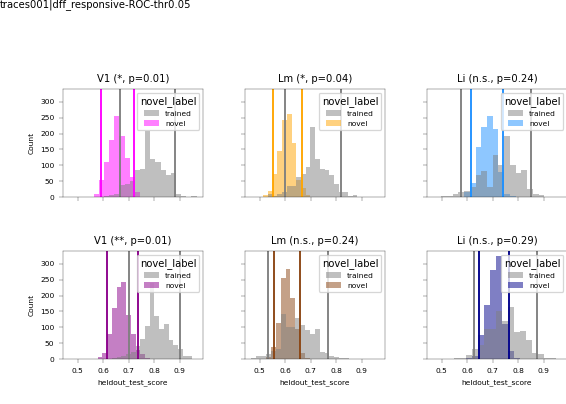

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs distns_95CI_test_trained-v-novelgreaterthan


In [33]:
metric='heldout_test_score'
v1='novel'
v2='trained'
data_['novel_label'] = [v1 if v else v2 for v in data_['novel'].values]
fig, axn = pl.subplots(2,3, figsize=(7,5), sharex=True, sharey=True)

for (va, rf_), vg in data_.groupby(['visual_area', 'rfs']):
    ri=1 if rf_=='matched' else 0
    vi = visual_areas.index(va)
    ax=axn[ri, vi]
    c1 = area_colors2[va] if rf_=='matched' else area_colors[va]
    c2 = [0.5]*3
    sns.histplot(x='heldout_test_score', hue='novel_label', bins=20, data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)

    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.novel][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)
    c_lo, c_hi = hutils.get_empirical_ci(vg[~(vg.novel)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    # Sig test
    # vg = df_[(df_.visual_area==va) & (df_.rfs=='matched')]
    meas_mean = vg[(vg.novel)]['heldout_test_score'].mean()
    trained_dist = sorted(vg[~(vg.novel)]['heldout_test_score'].values)
    n_below = len(np.where(trained_dist<meas_mean)[0])
    pv = n_below/len(trained_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'

    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv))
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
pplot.label_figure(fig, data_id)

figname = 'distns_95CI_test_trained-v-novel%s' % (overlap_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


In [34]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs'

In [35]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

# Is this difference significantly greater than chance?

In [36]:
# data_ = mean_df[(mean_df['n_cells']==max_ncells) 
#             & (mean_df['condition']=='data')].copy().reset_index(drop=True)
data_ = iterdf[(iterdf.n_cells==max_ncells) 
               & (iterdf.condition=='data') & (iterdf.iteration<=1000)].copy()

d_list=[]
for rf_cond, data_df in data_.groupby('rfs'):
    diff_ = dec.permutation_test_trained_v_novel(data_df)
    diff_['rfs'] = rf_cond
    d_list.append(diff_.reset_index(drop=True))
diffs = pd.concat(d_list, axis=0, ignore_index=True)

In [37]:
data_[(data_.visual_area==va) & (data_.iteration==1) 
      & (data_.train_transform==10) ] #& (data_.rfs=='all')]

,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,condition,train_transform,test_transform,...,iteration,n_cells,randi_cells,visual_area,datakey,intact,noise_corrs,overlap_thr,rfs,match_rfs
675030,0.000865,0.000346,0.642222,1.0,0.500000,1.0,5948,data,10.0,10.0,...,1,73,7868,V1,aggregate,True,intact,0,matched,True
675032,0.000865,0.000346,0.642222,1.0,0.550000,1.0,5948,data,10.0,20.0,...,1,73,7868,V1,aggregate,True,intact,0,matched,True
675033,0.000865,0.000346,0.642222,1.0,0.516667,1.0,5948,data,10.0,30.0,...,1,73,7868,V1,aggregate,True,intact,0,matched,True
675034,0.000865,0.000346,0.642222,1.0,0.500000,1.0,5948,data,10.0,40.0,...,1,73,7868,V1,aggregate,True,intact,0,matched,True
675035,0.000865,0.000346,0.642222,1.0,0.500000,1.0,5948,data,10.0,50.0,...,1,73,7868,V1,aggregate,True,intact,0,matched,True
1410030,0.000973,0.000418,0.500000,1.0,0.666667,1.0,1743,data,10.0,10.0,...,1,73,5677,V1,aggregate,True,intact,0,all,False
1410032,0.000973,0.000418,0.500000,1.0,0.603448,1.0,1743,data,10.0,20.0,...,1,73,5677,V1,aggregate,True,intact,0,all,False
1410033,0.000973,0.000418,0.500000,1.0,0.465517,1.0,1743,data,10.0,30.0,...,1,73,5677,V1,aggregate,True,intact,0,all,False
1410034,0.000973,0.000418,0.500000,1.0,0.465517,1.0,1743,data,10.0,40.0,...,1,73,5677,V1,aggregate,True,intact,0,all,False
1410035,0.000973,0.000418,0.500000,1.0,0.448276,1.0,1743,data,10.0,50.0,...,1,73,5677,V1,aggregate,True,intact,0,all,False


In [38]:
iterdf['iteration'].max()

999

<IPython.core.display.Javascript object>


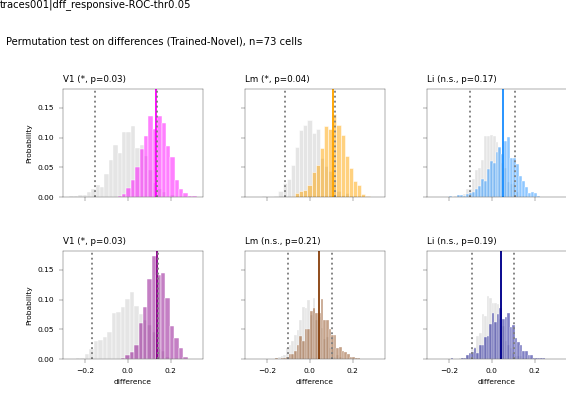

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs permutation_test_trained-v-novel-diffsgreaterthan


In [40]:
shuff_color=[0.8]*3

fig, axn = pl.subplots(2,3, figsize=(7,5), sharex=True, sharey=True)

for (va, rf_), vg in diffs.groupby(['visual_area', 'rfs']):
    ri=1 if rf_=='matched' else 0
    vi = visual_areas.index(va)
    ax=axn[ri, vi]

    curr_colors= area_colors2.copy() if rf_=='matched' else area_colors.copy()
    sns.histplot(x='difference', hue='trained_v_novel', data=vg, ax=ax, alpha=0.5,
                palette={'shuffled': shuff_color, 'true': curr_colors[va]},
                stat='probability', legend=True, common_norm=False,
                edgecolor='w')
    
    meas_mean = vg[vg.trained_v_novel=='true']['difference'].mean()
    ax.axvline(x=meas_mean, color=curr_colors[va])
    shuff_dist = sorted(vg[vg.trained_v_novel=='shuffled']['difference'].values)
    n_extreme = len(np.where(shuff_dist>=meas_mean)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.set_title('%s (%s, p=%.2f)' % (va, sig_str, pv), loc='left', fontsize=7)
    
    c_lo, c_hi = hutils.get_empirical_ci(shuff_dist)
    ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
    ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    if ri==0 and va=='Li':
        leg_h = pplot.custom_legend_markers(colors=[[0.5]*3, shuff_color],
                                           labels=['true', 'shuffled'], 
                                           use_patch=True)
        ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=None)
    else:
        ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
fig.text(0.01, 0.9,\
         "Permutation test on differences (Trained-Novel), n=%i cells" \
         % max_ncells, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'permutation_test_trained-v-novel-diffs%s' %overlap_str
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [41]:
diffs[diffs.trained_v_novel=='true'].groupby(['visual_area', 'rfs'])['difference'].describe()

count      mean       std       min       25%       50%  \
visual_area rfs                                                                 
Li          all      1000.0  0.050691  0.064007 -0.202632  0.009211  0.056579   
            matched  1000.0  0.041046  0.063108 -0.192105  0.001437  0.042672   
Lm          all      1000.0  0.107686  0.060101 -0.073851  0.069253  0.109626   
            matched  1000.0  0.042217  0.060449 -0.150000  0.004239  0.041667   
V1          all      1000.0  0.130177  0.057553 -0.037644  0.089943  0.131466   
            matched  1000.0  0.136132  0.051174 -0.030833  0.103333  0.135000   

                          75%       max  
visual_area rfs                          
Li          all      0.093398  0.223684  
            matched  0.082793  0.251316  
Lm          all      0.148060  0.279598  
            matched  0.079957  0.237069  
V1          all      0.172701  0.322414  
            matched  0.171667  0.281667

In [42]:
# data_ = iterdf[(iterdf.n_cells==max_ncells) & (iterdf.condition=='data')].copy()
data_ = iterdf[(iterdf.n_cells==max_ncells) 
               & (iterdf.condition=='data') ].copy()

# d_list=[]
# for rf_cond, data_df in data_.groupby('rfs'):
#     diff_ = dec.permutation_test_trained_v_novel(data_df)
#     diff_['rfs'] = rf_cond
#     d_list.append(diff_.reset_index(drop=True))
# diffs = pd.concat(d_list, axis=0, ignore_index=True)
d_list=[]
for rf_cond, data_df in data_.groupby('rfs'):
    data_scores = dec.average_within_iterations_by_ncells(data_df, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'iteration'])
    true_ = dec.calculate_difference_scores(data_scores)
    true_['rfs'] = rf_cond
    true_['condition'] = 'true'
    d_list.append(true_.reset_index(drop=True))
trained_minus_novel_true = pd.concat(d_list, axis=0, ignore_index=True)
trained_minus_novel_true.head()

,visual_area,n_cells,iteration,difference,rfs,condition
0,Li,73,0,0.112069,all,true
1,Lm,73,0,0.279598,all,true
2,V1,73,0,0.199713,all,true
3,Li,73,1,0.078736,all,true
4,Lm,73,1,0.113218,all,true


In [43]:
d_list=[]
shuff_ = data_.copy()
shuff_['rfs'] = shuff_.groupby(\
                        ['visual_area', 'iteration', 'novel'])['rfs']\
                        .transform(np.random.permutation)
for rf_cond, data_df in shuff_.groupby('rfs'):
    shuff_scores = dec.average_within_iterations_by_ncells(data_df, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'condition', 'iteration'])
    shuff_ = dec.calculate_difference_scores(shuff_scores)
    shuff_['rfs'] = rf_cond
    shuff_['condition'] = 'shuffled'
    d_list.append(shuff_.reset_index(drop=True))

trained_minus_novel_shuff = pd.concat(d_list, axis=0, ignore_index=True)

In [44]:
trained_minus_novel = pd.concat([trained_minus_novel_true, 
                                trained_minus_novel_shuff], axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


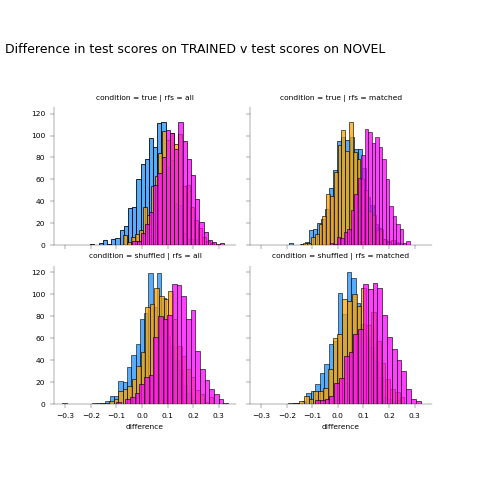

Text(0.01, 0.9, 'Difference in test scores on TRAINED v test scores on NOVEL')

In [45]:
#fig, axn = pl.subplots(1, 2, figsize=(6,3))
#ax=axn[0]

fg = sns.FacetGrid(col='rfs', data=trained_minus_novel, height=3, 
                  hue='visual_area', palette=area_colors,
                   row='condition')
fg.map(sns.histplot, 'difference')

# sns.histplot(x='difference', data=true_diffs[true_diffs], ax=ax,
#              hue='visual_area', palette=area_colors)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8)
fg.fig.text(0.01, 0.9, 'Difference in test scores on TRAINED v test scores on NOVEL')

<IPython.core.display.Javascript object>


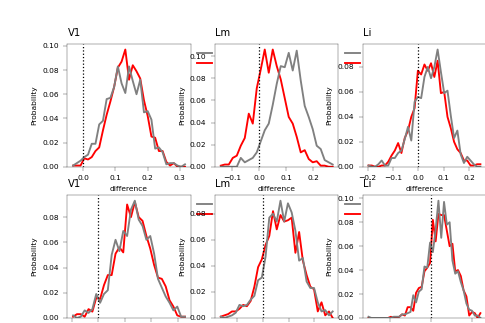

In [46]:
rf_cond_colors={'all': [0.5]*3, 'matched': 'r'}
fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)

for (cond, va), curr_scores in trained_minus_novel.groupby(['condition', 'visual_area']):
    ri=0 if cond=='true' else 1
    ax=axn[ri, visual_areas.index(va)]
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 cumulative=False, common_norm=False,
                 fill=False, element='poly', stat='probability', 
                 palette=rf_cond_colors, hue='rfs')
    ax.axvline(x=0, ls=':', c='k', lw=1)
    pplot.sns_histplot_legend(ax, title='')
    ax.set_title(va, loc='left')
    ax.set_box_aspect(1)
    

<IPython.core.display.Javascript object>


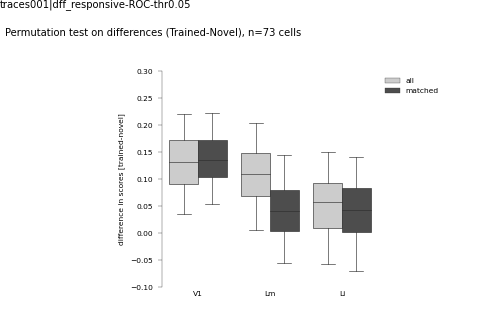

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs boxplot_match_vs_unmatched_trained-v-novel-diffsgreaterthan
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/generalization boxplot_match_vs_unmatched_trained-v-novel-diffsgreaterthan


In [47]:

rf_cond_colors={'all': [0.8]*3, 'matched': [0.3]*3}
fig, ax = pl.subplots( figsize=(6,4), dpi=100)
plotd =trained_minus_novel[trained_minus_novel.condition=='true']

sns.boxplot(x='visual_area', y='difference', data=plotd,
           ax=ax, hue='rfs', order=visual_areas, palette=rf_cond_colors,
            linewidth=0.5, fliersize=0, whis=(5, 95))
ax.set_box_aspect(1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.tick_params(which='both', axis='x', size=0)
sns.despine(bottom=True)
ax.set_xlabel('')
ax.set_ylim([-0.1, 0.3])
ax.set_ylabel('difference in scores [trained-novel]')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)
fig.text(0.01, 0.9,\
         "Permutation test on differences (Trained-Novel), n=%i cells" \
         % max_ncells, fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'boxplot_match_vs_unmatched_trained-v-novel-diffs%s' % overlap_str
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
print(FIGDIR, figname)

In [48]:
df_list=[]
for va, vg in trained_minus_novel_true.groupby('visual_area'):
    for i in np.arange(0, 500):
        d_ = vg.sample(2, replace=False)
        random_diff = d_.iloc[0]['difference'] - d_.iloc[1]['difference']
        df_ = pd.Series({'difference': random_diff, 
                  'visual_area': va, 'condition': 'shuffled'})
        df_list.append(df_)
randsamp = pd.concat(df_list, axis=1).T

<IPython.core.display.Javascript object>


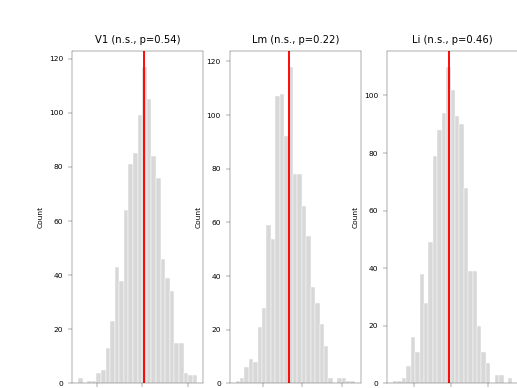

In [49]:
fig, axn = pl.subplots(1,3)

for va, vg in trained_minus_novel_true.groupby(['visual_area']):
    ax=axn[visual_areas.index(va)]
    # shuff_dist = randsamp[randsamp.visual_area==va]['difference'].values
    #sns.histplot(vg['difference'], ax=ax, color=[0.8]*3, edgecolor='w')
    true_diffs = vg[vg.rfs=='matched']['difference'].values \
                - vg[vg.rfs=='all']['difference'].values
    true_meandiff = np.mean(true_diffs)
    sns.histplot(true_diffs, ax=ax, color=[0.8]*3, edgecolor='w')
    ax.axvline(x=true_meandiff, color='r')
    
    sorted_dist = np.array(sorted(true_diffs))
    n_extreme = len(np.where(sorted_dist>=0)[0])
    pv = n_extreme/len(sorted_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    ax.set_title("%s (%s, p=%.2f)" % (va, sig_str, pv))

In [50]:
vg[vg.rfs=='matched'].values 

array([['V1', 73, 0, 0.0033333333333334103, 'matched', 'true'],
       ['V1', 73, 1, 0.04249999999999987, 'matched', 'true'],
       ['V1', 73, 2, 0.15000000000000002, 'matched', 'true'],
       ...,
       ['V1', 73, 997, 0.1875, 'matched', 'true'],
       ['V1', 73, 998, 0.18999999999999984, 'matched', 'true'],
       ['V1', 73, 999, 0.1974999999999998, 'matched', 'true']],
      dtype=object)

In [51]:
df_list=[]
for cond, cg in trained_minus_novel.groupby(['condition', 'visual_area']):
    df_ = cg.sort_values(by='iteration').reset_index(drop=True)
    diff_vals = df_[df_.rfs=='matched']['difference'].values \
                - df_[df_.rfs=='all']['difference'].values
    new_df = df_[['visual_area', 'iteration', 'condition']].drop_duplicates()
    new_df['difference'] = diff_vals
    df_list.append(new_df)
matched_minus_unmatched = pd.concat(df_list, axis=0, ignore_index=True)


<IPython.core.display.Javascript object>


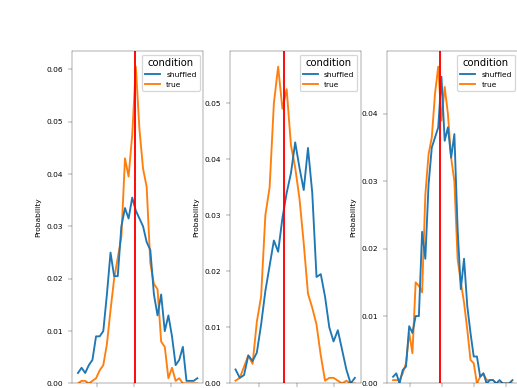

In [52]:
# sns.displot(x='difference', col='visual_area', col_order=visual_areas, 
#             data=matched_minus_unmatched,
#             hue='condition', height=2, cumulative=True, fill=False)

fig, axn = pl.subplots(1,3)
for va, vg in matched_minus_unmatched.groupby(['visual_area']):
    ax=axn[visual_areas.index(va)]
    # shuff_dist = randsamp[randsamp.visual_area==va]['difference'].values
    #sns.histplot(vg['difference'], ax=ax, color=[0.8]*3, edgecolor='w')
    sns.histplot(x='difference', ax=ax, data=vg, #edgecolor='w',
                 hue='condition', cumulative=False, common_norm=True,
                 stat='probability', element='poly', fill=False)
    meanv = vg[vg.condition=='true'].mean()['difference']
    
    ax.axvline(x=meanv, color='r')
    
#     sorted_dist = np.array(sorted(true_diffs))
#     n_extreme = len(np.where(sorted_dist>=0)[0])
#     pv = n_extreme/len(sorted_dist)
#     if pv<0.05:
#         sig_str='**' if pv<0.01 else '*'
#     else:
#         sig_str='n.s.'
#     ax.set_title("%s (%s, p=%.2f)" % (va, sig_str, pv))

In [53]:
vg[vg.condition=='true'].mean()

iteration     499.500000
difference      0.005955
dtype: float64

In [54]:
# true_diffs = diff_scores[diff_scores.condition=='true'].copy()
# shuff_diffs = diff_scores[diff_scores.condition=='shuffled'].copy()
va='Lm'
# vg[vg.rfs=='all'], vg[vg.rfs=='matched']

In [58]:
vg = matched_minus_unmatched[matched_minus_unmatched.visual_area==va]
vg

,visual_area,iteration,condition,difference
1000,Lm,0,shuffled,0.033333
1001,Lm,1,shuffled,0.022701
1002,Lm,2,shuffled,0.020115
1003,Lm,3,shuffled,-0.092816
1004,Lm,4,shuffled,-0.076437
...,...,...,...,...
4995,Lm,995,true,-0.080172
4996,Lm,996,true,-0.109195
4997,Lm,997,true,-0.050575
4998,Lm,998,true,-0.151149


In [59]:
trained_minus_novel

,visual_area,n_cells,iteration,difference,rfs,condition
0,Li,73,0,0.112069,all,true
1,Lm,73,0,0.279598,all,true
2,V1,73,0,0.199713,all,true
3,Li,73,1,0.078736,all,true
4,Lm,73,1,0.113218,all,true
...,...,...,...,...,...,...
11995,Lm,73,998,0.129023,matched,shuffled
11996,V1,73,998,0.237213,matched,shuffled
11997,Li,73,999,0.063823,matched,shuffled
11998,Lm,73,999,0.085632,matched,shuffled


<IPython.core.display.Javascript object>


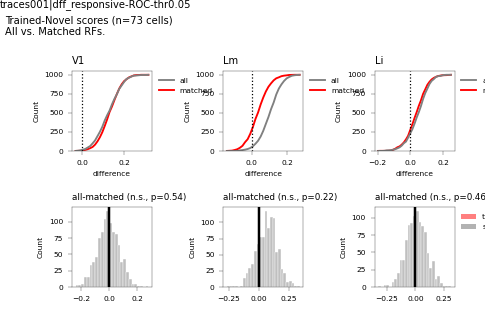

Text(0.01, 0.9, 'Trained-Novel scores (n=73 cells)\nAll vs. Matched RFs.')

In [63]:
rf_cond_colors={'all': [0.5]*3, 'matched': 'r'}
fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)

diff_df = trained_minus_novel[trained_minus_novel.condition=='true']

for va, curr_scores in diff_df.groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[0, vi]
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 cumulative=True, common_norm=False,
                 fill=False, element='poly',
                 palette=rf_cond_colors, hue='rfs')
    ax.axvline(x=0, ls=':', c='k', lw=1)
    pplot.sns_histplot_legend(ax, title='')
    ax.set_title(va, loc='left')

    ax=axn[1, vi]
    v1_vals = curr_scores[curr_scores.rfs=='all'].sort_values(by='iteration')\
                ['difference'].values
    v2_vals = curr_scores[curr_scores.rfs=='matched'].sort_values(by='iteration')\
                ['difference'].values
    curr_diffs = v1_vals - v2_vals
    true_diff = np.mean(curr_diffs)

    sns.histplot(curr_diffs, ax=ax, color=[0.5]*3, alpha=0.5, edgecolor='w')
    sorted_dist = np.array(sorted(curr_diffs))
    n_extreme = len(np.where(sorted_dist<=0)[0])
    pv = n_extreme/len(sorted_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    if vi==2:
        legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                    labels=['true diffs', 'shuffled'], 
                                    use_patch=True, alpha=0.5)
        ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.axvline(x=0, ls='-', c='k', lw=2)
    #ax.axvline(x=shuff_diff, ls='-', c='k', lw=2)
    ax.set_title('all-matched (%s, p=%.2f)' % (sig_str, pv),
                 loc='left', fontsize=7)
    
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.7, hspace=0.7, bottom=0.2, top=0.8, right=0.85)

pplot.label_figure(fig,data_id)
fig.text(0.01, 0.9, 
    'Trained-Novel scores (n=%i cells)\nAll vs. Matched RFs.' \
         % max_ncells, fontsize=8)

In [68]:
trained_minus_novel

,visual_area,n_cells,iteration,difference,rfs,condition
0,Li,73,0,0.112069,all,true
1,Lm,73,0,0.279598,all,true
2,V1,73,0,0.199713,all,true
3,Li,73,1,0.078736,all,true
4,Lm,73,1,0.113218,all,true
...,...,...,...,...,...,...
11995,Lm,73,998,0.129023,matched,shuffled
11996,V1,73,998,0.237213,matched,shuffled
11997,Li,73,999,0.063823,matched,shuffled
11998,Lm,73,999,0.085632,matched,shuffled


<IPython.core.display.Javascript object>


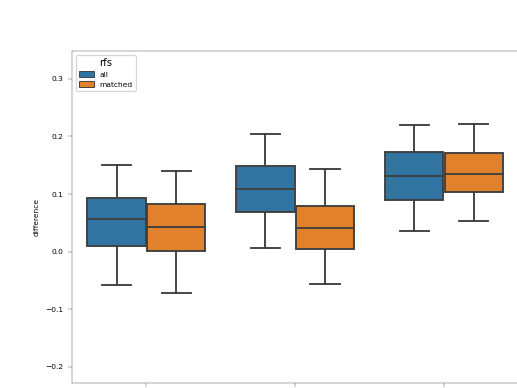

<AxesSubplot:xlabel='visual_area', ylabel='difference'>

In [70]:
fig, ax = pl.subplots()
sns.boxplot(x='visual_area', y='difference', ax=ax,
            data=trained_minus_novel[trained_minus_novel.condition=='true'], 
            hue='rfs', fliersize=0, whis=(5, 95))


<IPython.core.display.Javascript object>


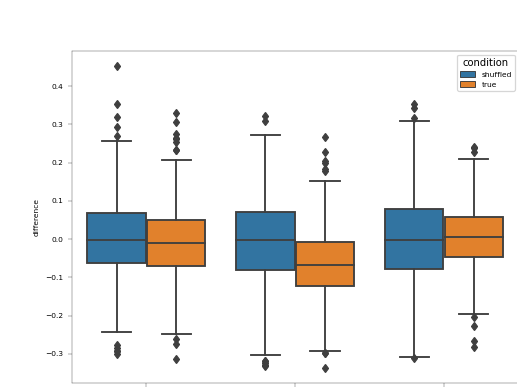

<AxesSubplot:xlabel='visual_area', ylabel='difference'>

In [64]:
fig, ax = pl.subplots()
sns.boxplot(x='visual_area', y='difference', ax=ax,
            data=matched_minus_unmatched, hue='condition')


<IPython.core.display.Javascript object>


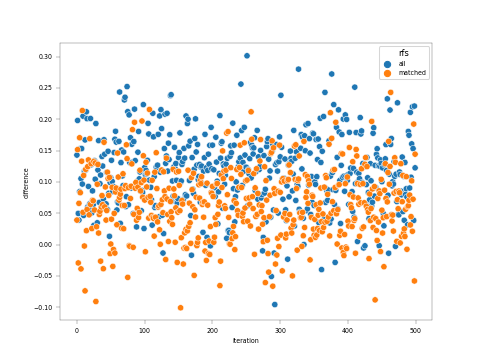

,iteration,difference,rfs
1,0,0.142816,all
4,1,0.197989,all
7,2,0.049713,all
10,3,0.039080,all
13,4,0.084483,all
...,...,...,...
2986,495,0.021264,matched
2989,496,0.072414,matched
2992,497,0.192241,matched
2995,498,-0.058046,matched


In [208]:
fig, ax = pl.subplots()

va='Lm'
curr_scores = diff_scores[(diff_scores.visual_area==va)
                         & (diff_scores.condition=='true')]

# v1_vals = curr_scores[curr_scores.rfs=='all'].sort_values(by='iteration')\
#             ['difference'].values
# v2_vals = curr_scores[curr_scores.rfs=='matched'].sort_values(by='iteration')\
#             ['difference'].values

sns.scatterplot(x='iteration', y='difference', data=curr_scores, ax=ax,
                hue='rfs')

curr_scores[['iteration', 'difference', 'rfs']]

In [149]:
v1_vals = curr_scores[curr_scores.rfs=='all']['difference'].values
v2_vals = curr_scores[curr_scores.rfs=='matched']['difference'].values
v1_mean = v1_vals.mean()
v2_mean = v2_vals.mean()
overall_mean = curr_scores['difference'].mean()


In [150]:
h0_v1 = (v1_vals - v1_mean) + overall_mean 
h0_v2 = (v2_vals - v2_mean) + overall_mean 

h0_diff= h0_v1-h0_v2
hA_diff= v1_vals-v2_vals


<IPython.core.display.Javascript object>


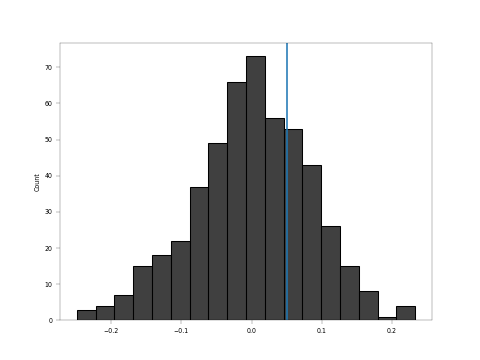

143.00199600798402


In [156]:
fig, ax = pl.subplots()
sns.histplot(h0_diff, color='k')
# sns.histplot(hA_diff, color='r')
ax.axvline(x=hA_diff.mean())

p_larger = len(np.where(h0_diff>=hA_diff.mean())[0])
print(p_larger+1/(len(hA_diff)+1))

In [ ]:
print(p_larger+1/(len(hA_diff)+1))

In [160]:
p_larger/500.

0.286

In [157]:
(len(hA_diff)+1)

501

<IPython.core.display.Javascript object>


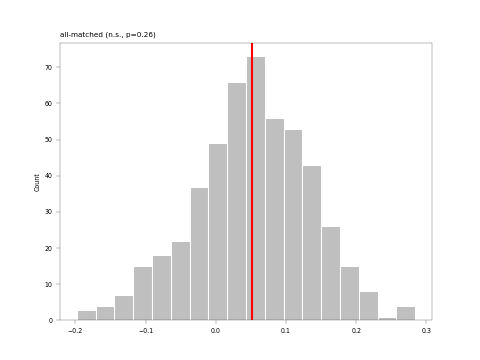

Text(0.0, 1.0, 'all-matched (n.s., p=0.26)')

In [135]:
v1_df = curr_scores[curr_scores.rfs=='all'][['iteration', 'difference', 'rfs']].copy()
v2_df = curr_scores[curr_scores.rfs=='matched'][['iteration', 'difference', 'rfs']].copy()

fig, ax = pl.subplots()
diffs_ = pd.merge(v1_df, v2_df, on=['iteration'], how='outer', 
             suffixes=('_all', '_matched'))
curr_diffs = diffs_['difference_all'] - diffs_['difference_matched']
true_diff = curr_diffs.mean()

sorted_dist = np.array(sorted(curr_diffs))
sns.histplot(sorted_dist, ax=ax, color=[0.5]*3,alpha=0.5, edgecolor='w')
n_extreme = len(np.where(sorted_dist<=0)[0])
pv = n_extreme/len(sorted_dist)
if pv<0.05:
    sig_str='**' if pv<0.01 else '*'
else:
    sig_str='n.s.'
if vi==2:
    legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                labels=['true diffs', 'shuffled'], 
                                use_patch=True, alpha=0.5)
    ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
ax.axvline(x=true_diff, ls='-', c='r', lw=2)
ax.set_title('all-matched (%s, p=%.2f)' % (sig_str, pv),
             loc='left', fontsize=7)

In [129]:
import scipy.stats as spstats
from statsmodels.graphics.gofplots import qqplot


In [126]:
spstats.normaltest(curr_diffs, axis=0)

NormaltestResult(statistic=3.12901041351077, pvalue=0.20919149410845364)

<IPython.core.display.Javascript object>


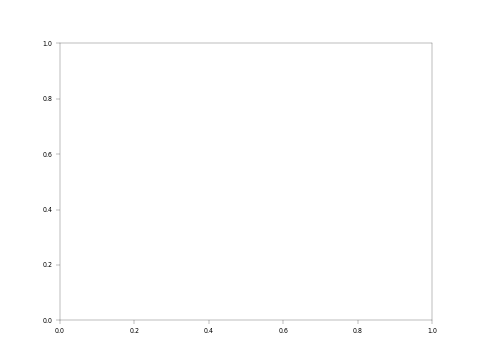

<IPython.core.display.Javascript object>


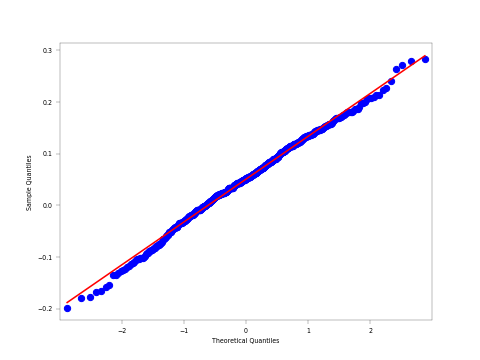

Statistics=0.996, p=0.179
Sample looks Gaussian (fail to reject H0)


In [133]:
fig, ax = pl.subplots()
qqplot(curr_diffs, line='s')

# normality test
stat, p = spstats.shapiro(curr_diffs)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
    

<IPython.core.display.Javascript object>


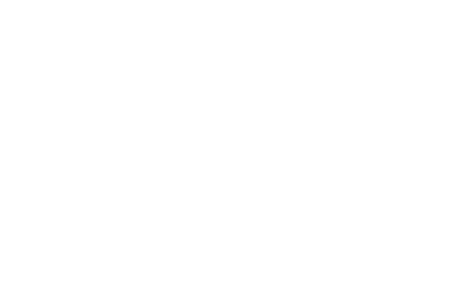

NameError: name 'shuff_diff' is not defined

In [63]:
%matplotlib notebook
# v1='Li'
# v2 = 'Lm'
v_combos = list(itertools.combinations(visual_areas, 2))
s_list=[]
fig, axn = pl.subplots(2, 3, figsize=(6,4), dpi=100)
for vi, (v1, v2) in enumerate(v_combos):
    # Original diff. distributions
    curr_scores = diff_scores[diff_scores.visual_area.isin([v1, v2])].copy()
    ax=axn[0, vi]
    sns.histplot(x='difference', data=curr_scores, ax=ax,
                 palette=area_colors, hue='visual_area', edgecolor='w')
    ax.axvline(x=0, ls=':', c='k', lw=1)
    pplot.sns_histplot_legend(ax, title='')
    
    v1_vals = diff_scores[diff_scores.visual_area==v1]['difference'].values
    v2_vals = diff_scores[diff_scores.visual_area==v2]['difference'].values
    curr_diffs = v1_vals - v2_vals
    true_diff = np.mean(curr_diffs)

    # diffs
    ax=axn[1, vi]
    sns.histplot(curr_diffs, ax=ax, color=[0.5]*3, alpha=0.5, edgecolor='w')
    sorted_dist = np.array(sorted(curr_diffs))
    n_extreme = len(np.where(sorted_dist>=true_diff)[0])
    pv = n_extreme/len(shuff_dist)
    if pv<0.05:
        sig_str='**' if pv<0.01 else '*'
    else:
        sig_str='n.s.'
    if vi==2:
        legh = pplot.custom_legend_markers(colors=['r', [0.4]*3], 
                                    labels=['true diffs', 'shuffled'], 
                                    use_patch=True, alpha=0.5)
        ax.legend(handles=legh, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.axvline(x=true_diff, ls=':', c='r', lw=1)
    ax.set_title('%s-%s (%s, p=%.2f)' % (v1, v2, sig_str, pv),
                 loc='left', fontsize=7)
    stats0 = pd.Series({'v1': v1, 'v2': v2, 'true_diff': true_diff,
                       'shuff_diff': shuff_diff, 'p-val': pv})
    s_list.append(stats0)
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.7, hspace=0.7, bottom=0.1, right=0.85)

# pplot.label_figure(fig,data_id)
# fig.text(0.01, 0.9, 
#     'Trained-Novel scores (n=%i cells)\nTrue diffs. vs Shuffle area labels' \
#          % curr_ncells, fontsize=8)

# figname = 'trained_vs_novel_shuffle_area_labels_n%icells' % curr_ncells

# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [33]:
import pingouin as pg

In [36]:
score_list=[]
for rf_cond, df_ in data_.groupby(['rfs']):
    byiter = dec.average_within_iterations_by_ncells(df_, 
                                    analysis_type='by_ncells',
                                    test_type='size_single',
                                    grouper=['visual_area', 'condition', 'iteration'])
    scores_ = dec.calculate_difference_scores(byiter)
    scores_['rfs'] = rf_cond
    score_list.append(scores_)
all_scores0 = pd.concat(score_list, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


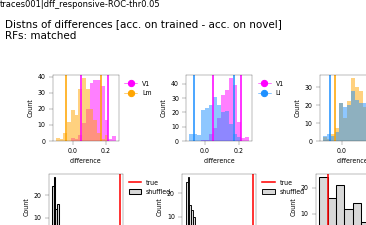

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls/match_rfs compare_by_area_difference_scores_rfs-matched


In [37]:
max_iter=200
n_shuff=100
p_vals = []
metric='difference'
v_combos = list(itertools.combinations(visual_areas, 2))

rfs_cond='matched'
all_scores = all_scores0[all_scores0.rfs==rfs_cond].copy()

fig, axn = pl.subplots(2, len(v_combos), figsize=(6.5,4))
for ai, (v1, v2) in enumerate(v_combos):
    v_list = [v1, v2]
    a_ = all_scores[all_scores.visual_area==v1][metric]
    b_ = all_scores[all_scores.visual_area==v2][metric]
    true_ = abs(a_.mean() - b_.mean())

    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(n_shuff):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:max_iter])
        v = np.mean(combined_[max_iter:])
        diff_s = abs(i-v)
        shuff_.append(diff_s)
    shuff = np.array(shuff_)
    pv_ = len(np.where(shuff>=true_)[0])/n_shuff
    p_vals.append(pd.Series({'v1': v1, 'v2': v2, 'p_val': pv_}))
    
    ax=axn[1, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    ax=axn[0, ai]
    c1= area_colors[v1]
    c2 = c2=area_colors[v2]
    sns.histplot(x=metric, hue='visual_area', ax=ax,
                 data=all_scores[all_scores.visual_area.isin(v_list)], 
                 palette={v1:c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(all_scores[all_scores.visual_area==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(all_scores[all_scores.visual_area==v2][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.75, wspace=0.8, hspace=0.5)
fig.text(0.01, 0.87, \
         "Distns of differences [acc. on trained - acc. on novel]\nRFs: %s" % rfs_cond)

pplot.label_figure(fig, data_id)
figname = 'compare_by_area_difference_scores_rfs-%s' % rfs_cond
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [255]:
p_vals

[v1        V1
 v2        Lm
 p_val    0.0
 dtype: object,
 v1        V1
 v2        Li
 p_val    0.0
 dtype: object,
 v1        Lm
 v2        Li
 p_val    0.0
 dtype: object]

In [241]:
pval_df = pd.concat(p_vals, axis=1).T
pval_df['p_val'] = pval_df['p_val'].astype(float)
pval_df

,v1,v2,p_val
0,V1,Lm,0.000
1,V1,Li,0.000
2,Lm,Li,0.968


In [239]:
reject, pvals_corr = pg.multicomp(pval_df['p_val'].values, method='bonf')
print(reject, pvals_corr)

[False  True  True] [0.096 0.    0.   ]


In [216]:
v1 ='Li'
v2 = 'V1'
a = all_scores[all_scores.visual_area==v1]['difference'].values
b =  all_scores[all_scores.visual_area==v2]['difference'].values

n_extreme = len(np.where(a>=b)[0])
pv = n_extreme/len(shuff_diff_scores)
print(pv, n_extreme)

0.194 97


<IPython.core.display.Javascript object>


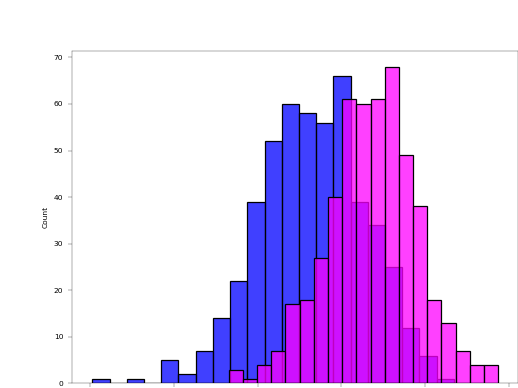

<AxesSubplot:ylabel='Count'>

In [217]:
fig, ax = pl.subplots()
sns.histplot(a, color='blue', ax=ax)
sns.histplot(b, color='magenta', ax=ax)

In [225]:
v1='V1'
v2='Lm'
curr_areas = [v1, v2]
df_ = all_scores[(all_scores.visual_area.isin(curr_areas))].copy()
# df_['difference_abs'] = df_['difference'].abs()
#diff_in_diffscore = df_
mean1 = df_[df_.visual_area==v1]['difference'].mean()
mean2 = df_[df_.visual_area==v2]['difference'].mean()
meas_diff = (mean1-mean2)
# true_diff_scores = (df_[df_.visual_area==v1]['difference'].values \
#                         - df_[df_.visual_area==v2]['difference'].values)
# meas_diff
meas_diff

0.007283333333333308

In [226]:
# df_['visual_area'] = df_.groupby(['iteration'])['visual_area'].transform(np.random.permutation)

In [227]:
# df_['visual_area'] = df_['visual_area'].sample(frac=1).values
# shuff_diff_scores = (df_[df_.visual_area==v1]['difference'].values \
#                         - df_[df_.visual_area==v2]['difference'].values)

In [228]:
n_iters = 500
shuff_diff_scores = []
for i in range(n_iters):
    randi = np.random.randint(0, 1000)
    df_['visual_area'] = df_['visual_area'].sample(frac=1, random_state=randi).values
    mean1 = df_[df_.visual_area==v1]['difference'].mean()
    mean2 = df_[df_.visual_area==v2]['difference'].mean()
    diff_ = (mean1-mean2)
    shuff_diff_scores.append(diff_)
               

<IPython.core.display.Javascript object>


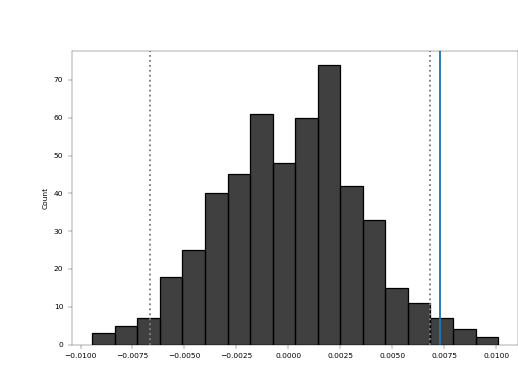

0.02


In [229]:
fig, ax = pl.subplots()
sns.histplot(shuff_diff_scores, color='k')
#sns.histplot(true_diff_scores, color='r')

c_lo, c_hi = hutils.get_empirical_ci(shuff_diff_scores)
ax.axvline(x=c_lo, color=[0.5]*3, ls=':')
ax.axvline(x=c_hi, color=[0.5]*3, ls=':')
    
ax.axvline(x=meas_diff)
pl.subplots_adjust(bottom=0.2)

n_extreme = len(np.where(shuff_diff_scores>=meas_diff)[0])
pv = n_extreme/len(shuff_diff_scores)
print(pv)


0.024


<IPython.core.display.Javascript object>


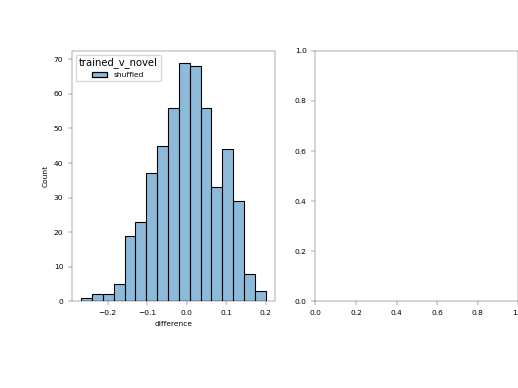

In [83]:
vg = diffs[(diffs.visual_area=='V1') & (diffs.rfs=='matched')
          & (vg.trained_v_novel=='shuffled')].copy()
vg[vg.trained_v_novel=='shuffled']
fig, axn = pl.subplots(1,2)
ax=axn[0]
sns.histplot(x='difference', data=vg, hue='trained_v_novel', ax=ax)
pl.subplots_adjust(bottom=0.3)

In [126]:
vg.groupby(['rfs', 'trained_v_novel']).count()

visual_area  n_cells  iteration  difference
rfs     trained_v_novel                                             
matched shuffled                 500      500        500         500
        true                     500      500        500         500

In [127]:
vg[vg.trained_v_novel=='shuffled']

,visual_area,n_cells,iteration,difference,trained_v_novel,rfs
4502,V1,96,0,-0.085057,shuffled,matched
4505,V1,96,1,0.172989,shuffled,matched
4508,V1,96,2,0.186782,shuffled,matched
4511,V1,96,3,0.011494,shuffled,matched
4514,V1,96,4,-0.101149,shuffled,matched
...,...,...,...,...,...,...
5987,V1,96,495,-0.133908,shuffled,matched
5990,V1,96,496,-0.148276,shuffled,matched
5993,V1,96,497,-0.121264,shuffled,matched
5996,V1,96,498,-0.139655,shuffled,matched


<IPython.core.display.Javascript object>


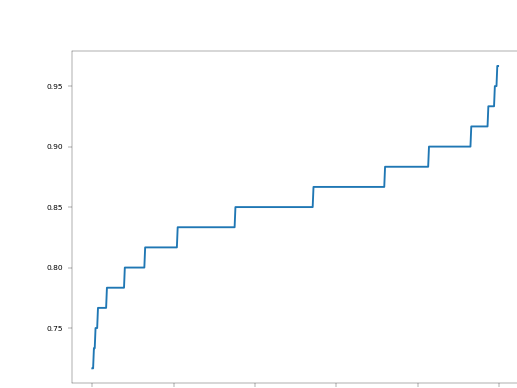

In [75]:
pl.figure()
pl.plot(vg[~(vg.novel)].sort_values(by='heldout_test_score')['heldout_test_score'].values)


In [32]:
data_df = mean_df[(mean_df.condition=='data') & (mean_df.n_cells==max_ncells)]


In [33]:
data_df.groupby(['visual_area', 'rfs', 'novel']).count()

condition  iteration  n_cells  fit_time  \
visual_area rfs     novel                                            
Li          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
Lm          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   
V1          all     False        500        500      500       500   
                    True         500        500      500       500   
            matched False        500        500      500       500   
                    True         500        500      500       500   

                           score_time  test_score  train_score  \
visual_area rfs     novel                                        
Li          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
Lm          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   
V1          all     False         500         500          500   
                    True          500         500          500   
            matched False         500         500          500   
                    True          500         500          500   

                           heldout_test_score    C  randi  train_transform  \
visual_area rfs     novel                                                    
Li          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
Lm          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   
V1          all     False                 500  500    500              500   
                    True                  500  500    500              500   
            matched False                 500  500    500              500   
                    True                  500  500    500              500   

                           test_transform  n_trials  randi_cells  intact  \
visual_area rfs     novel                                                  
Li          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
Lm          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              500       500          500     500   
V1          all     False             500       500          500     500   
                    True              500       500          500     500   
            matched False             500       500          500     500   
                    True              50

In [36]:
d_list=[]
for (va, rf_cond), cg in data_df.sort_values(by='iteration')\
                .groupby(['visual_area', 'rfs']):
    novel_scores = cg[cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    trained_scores = cg[~cg.novel].sort_values(by='iteration')['heldout_test_score'].values
    diffs = trained_scores - novel_scores
    df_ = pd.DataFrame({'trained_minus_novel': diffs})
    df_['visual_area'] = va
    df_['condition'] = 'data'
    df_['rfs'] = rf_cond
    df_['iteration'] = cg[cg.novel].sort_values(by='iteration')['iteration'].values
    d_list.append(df_)
diffdf = pd.concat(d_list, axis=0)

<IPython.core.display.Javascript object>


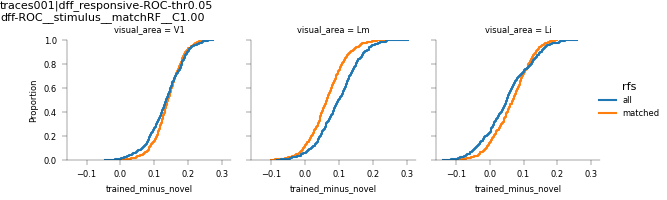

In [37]:
# fig, ax = pl.subplots()
g = sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='ecdf', 
           )
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(g.fig, '%s\n%s' % (data_id, aggr_id))

figname = 'diff_trained-minus-novel_matchrf-v-all'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


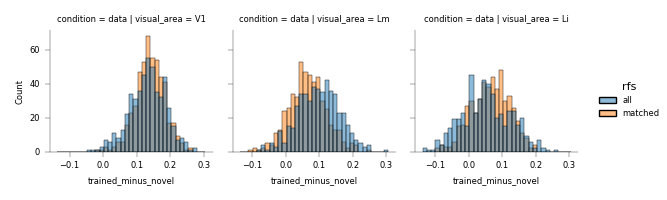

In [38]:
sns.displot(hue='rfs', x='trained_minus_novel',  col='visual_area',
           data=diffdf, height=2, col_order=visual_areas, #hue_norm=True,
            kind='hist', row='condition'
           )

<IPython.core.display.Javascript object>


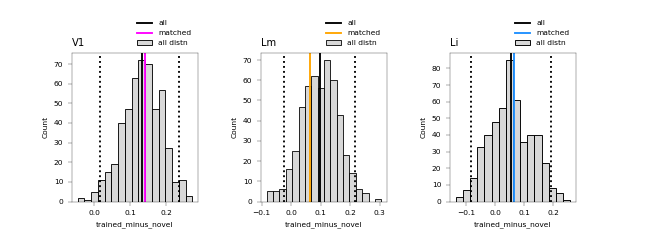

In [50]:
metric='trained_minus_novel'
fig, axn = pl.subplots(1,3, figsize=(8,3))

for va, vg in diffdf.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x=metric, data=vg[vg['rfs']=='all'], ax=ax,
            color=[0.8]*3, label='all distn')
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg['rfs']=='all'][metric].values, ci=0.95)
    ax.axvline(x=c_lo, color='k', ls=':')
    ax.axvline(x=c_hi, color='k', ls=':')
    mean_v0 = vg[vg['rfs']=='all'][metric].mean()
    ax.axvline(x=mean_v0, color='k', label='all')
    
    # sns.histplot(x='trained_minus_novel', data=plotd[plotd['rfs']=='matched'], ax=ax)
    mean_v = vg[vg['rfs']=='matched'][metric].mean()
    ax.axvline(x=mean_v, color=area_colors[va], label='matched')
    ax.set_title(va, loc='left')
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False)
    
pl.subplots_adjust(bottom=0.25, right=0.8, left=0.1, wspace=0.5, top=0.8)

In [51]:
df_ = diffdf[(diffdf['condition']=='data')].copy()
df_.groupby(['visual_area', 'rfs']).count()

trained_minus_novel  condition  iteration
visual_area rfs                                               
Li          all                      500        500        500
            matched                  500        500        500
Lm          all                      500        500        500
            matched                  500        500        500
V1          all                      500        500        500
            matched                  500        500        500

<IPython.core.display.Javascript object>


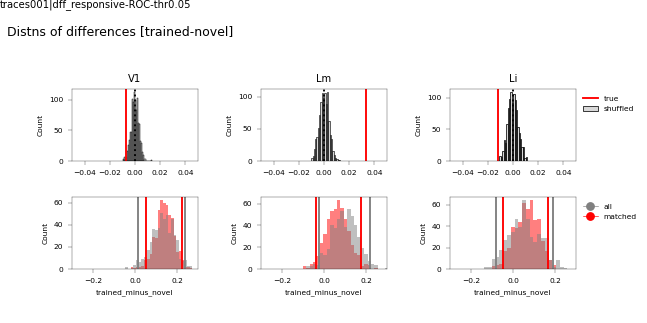

1.0
0.0


No handles with labels found to put in legend.


0.0
1.0
0.985
0.015
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls shuffle_test_DIFF_distn


In [61]:
v1='all'
v2='matched'
c1=[0.5]*3
c2='r'
fig, axn = pl.subplots(2, 3, figsize=(8,4))
for va, vg in diffdf.groupby(['visual_area']):
    # Shuffle test
    a_ = vg[(vg.rfs=='matched')][metric]
    b_ = vg[(vg.rfs=='all')][metric]
    true_ = b_.mean() - a_.mean()
    combined_ = pd.concat([a_, b_], axis=0, ignore_index=True).values
    shuff_=[]
    for n in range(1000):
        np.random.shuffle(combined_)
        i = np.mean(combined_[0:500])
        v = np.mean(combined_[500:])
        shuff_.append(i-v)
    shuff = np.array(shuff_)

    ai = visual_areas.index(va)
    ax=axn[0, ai]
    sns.histplot(shuff, color=[0.8]*3, ax=ax, label='shuffled')
    ax.axvline(x=true_, color='r', label='true')
    print(len(np.where(shuff>true_)[0])/1000.)
    print(len(np.where(shuff<true_)[0])/1000.)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    ax.set_xlim([-0.05, 0.05])
    ax.axvline(x=0, color='k', ls=':')

    ax.set_title(va)
    
    # Plot original distns with CI
    ax=axn[1, ai]
    sns.histplot(x=metric, hue='rfs', data=vg, ax=ax,
                palette={v1: c1, v2: c2}, fill=True, edgecolor=None)
    c_lo, c_hi = hutils.get_empirical_ci(vg[vg.rfs==v1][metric].values)
    ax.axvline(x=c_lo, color=c1)
    ax.axvline(x=c_hi, color=c1)

    c_lo, c_hi = hutils.get_empirical_ci(vg[(vg.rfs==v2)][metric].values)
    ax.axvline(x=c_lo, color=c2)
    ax.axvline(x=c_hi, color=c2)
    ax.set_xlim([-0.3, 0.3])
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()

ax=axn[0, 2]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax=axn[1,2]
leg_h = pplot.custom_legend_markers(colors=[c1, c2], labels=[v1, v2])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.75, wspace=0.5, hspace=0.5)
fig.text(0.01, 0.9, "Distns of differences [trained-novel]")

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25)

pplot.label_figure(fig, data_id)

figname = 'shuffle_test_DIFF_distn'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


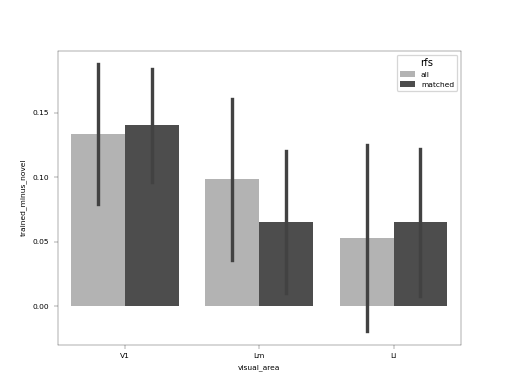

In [70]:
rfmatch_colors={'all': [0.7]*3, 'matched': [0.3]*3}
fig, ax = pl.subplots()

sns.barplot(x='visual_area', y='trained_minus_novel', data=diffdf, ax=ax,
           hue='rfs', palette=rfmatch_colors, order=visual_areas, ci='sd')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2)